In [1]:
# ============================
# TASK 1 - ADULT INCOME (TABULAR)
# ============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras import layers, models

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [3]:
# ============================
# Load Adult Income dataset
# ============================

import zipfile
import io

possible_paths = [
    "/content/adult.csv",
    "/content/AdultIncome.csv",
    "/content/adult_income.csv"
]

csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    try:
        from google.colab import files
        print("Please upload the Adult Income CSV file (e.g. adult.csv) or the adult.zip archive...")
        uploaded = files.upload()
        uploaded_filename = list(uploaded.keys())[0]
        print("Using uploaded file:", uploaded_filename)

        if uploaded_filename.endswith('.zip'):
            print(f"Unzipping {uploaded_filename}...")
            with zipfile.ZipFile(io.BytesIO(uploaded[uploaded_filename]), 'r') as zip_ref:
                zip_ref.extractall("/content/")
            csv_path = "/content/adult.data" # Assuming adult.data is the correct file inside the zip
            if not os.path.exists(csv_path):
                raise RuntimeError(f"Expected '{csv_path}' not found after unzipping '{uploaded_filename}'. Please ensure 'adult.data' is in the zip or upload the data file directly.")
            print(f"Using unzipped file: {csv_path}")
        else:
            csv_path = uploaded_filename

    except Exception as e:
        raise RuntimeError("Could not find or upload Adult dataset.") from e

df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Please upload the Adult Income CSV file (e.g. adult.csv) or the adult.zip archive...


Saving adult.zip to adult (1).zip
Using uploaded file: adult (1).zip
Unzipping adult (1).zip...
Using unzipped file: /content/adult.data
Dataset shape: (32560, 15)
Columns: ['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States', ' <=50K']


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [5]:
# ============================
# Basic cleaning
# ============================

# Try to detect the target column
# The actual target column is named ' <=50K', which is not automatically detected.
# We will explicitly define it and also rename the columns for better readability.

# Rename columns to remove leading spaces and make them more descriptive
df.columns = df.columns.str.strip()
df.rename(columns={'39': 'age', 'State-gov': 'workclass', '77516': 'fnlwgt', 'Bachelors': 'education', '13': 'education_num',
                   'Never-married': 'marital_status', 'Adm-clerical': 'occupation', 'Not-in-family': 'relationship',
                   'White': 'race', 'Male': 'sex', '2174': 'capital_gain', '0': 'capital_loss', '40': 'hours_per_week',
                   'United-States': 'native_country', '<=50K': 'income'},
          inplace=True)

target_col = 'income'
print("Using target column:", target_col)

# Replace '?' or ' ?' with NaN
df = df.replace("?", np.nan).replace(" ?", np.nan)

print("Missing values per column:")
print(df.isna().sum())

# Drop rows with missing values (simple strategy)
df = df.dropna().reset_index(drop=True)
print("Shape after dropping missing:", df.shape)

# Separate features & target
X = df.drop(columns=[target_col])
y = df[target_col].astype(str).str.strip()

print("Target classes:", y.unique())
class_counts = y.value_counts()
print("\nClass balance:")
print(class_counts)

Using target column: income
Missing values per column:
age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64
Shape after dropping missing: (30161, 15)
Target classes: ['<=50K' '>50K']

Class balance:
income
<=50K    22653
>50K      7508
Name: count, dtype: int64


In [6]:
# ============================
# Train/Test split + preprocessing
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Detect categorical vs numerical columns
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# We'll reuse this preprocessor in pipelines and ANN


Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Numeric columns: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


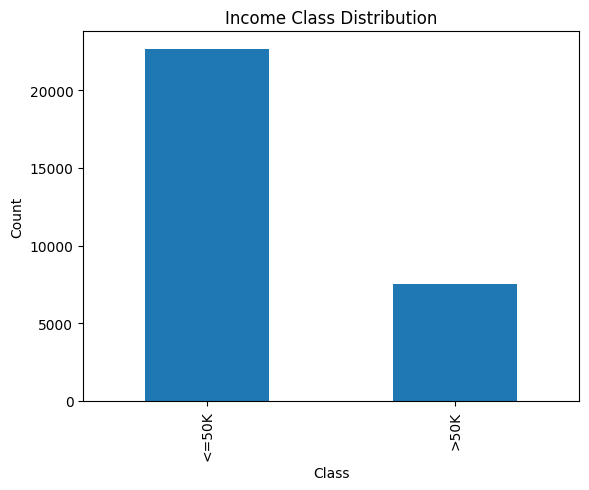

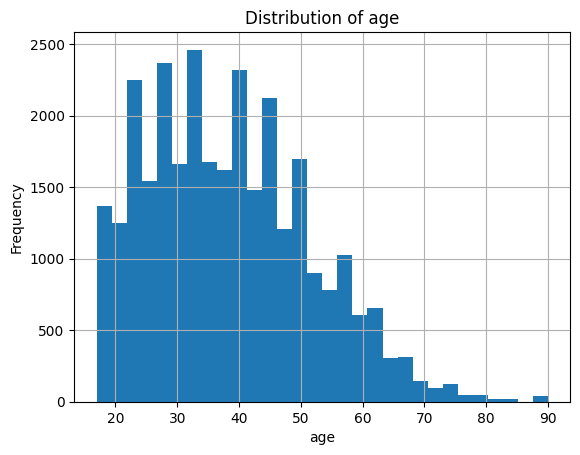

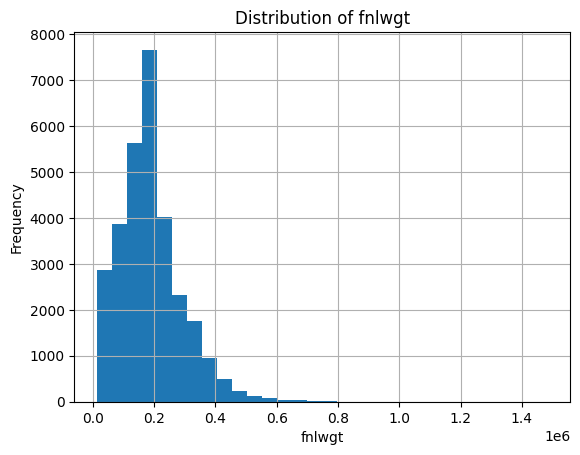

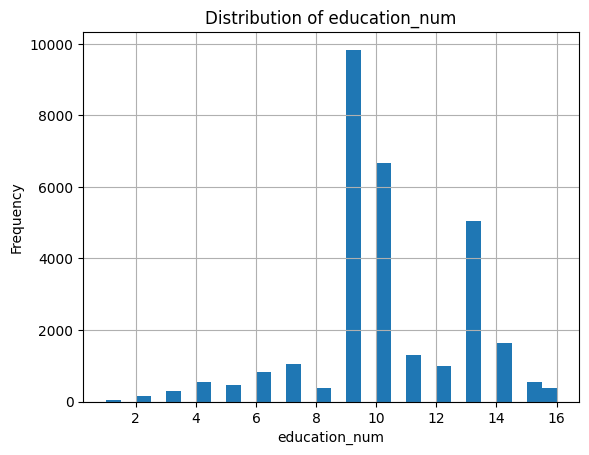

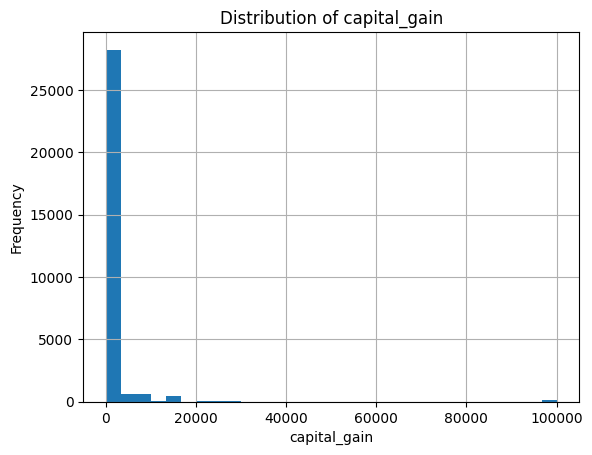

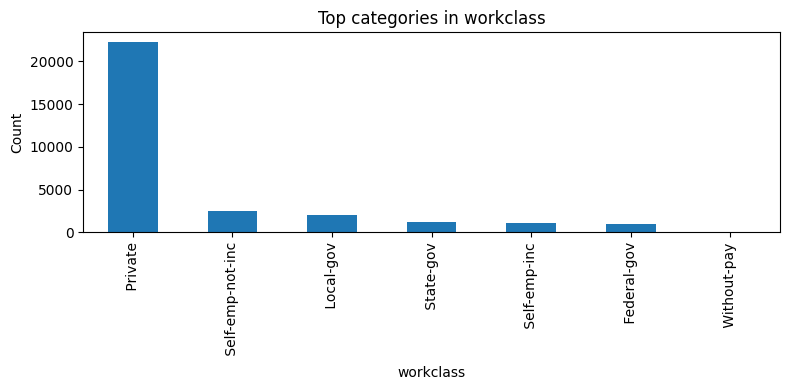

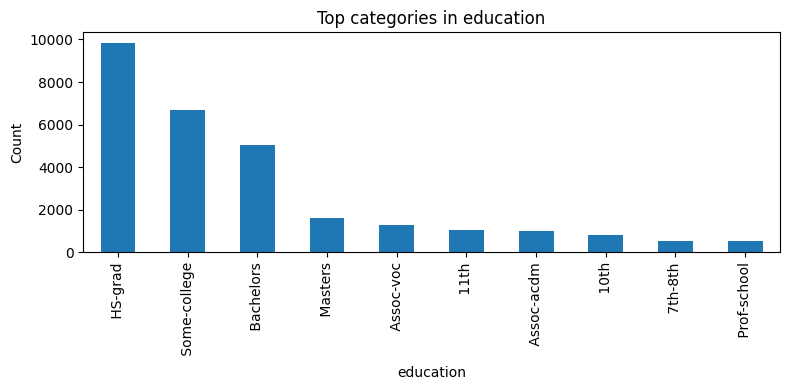

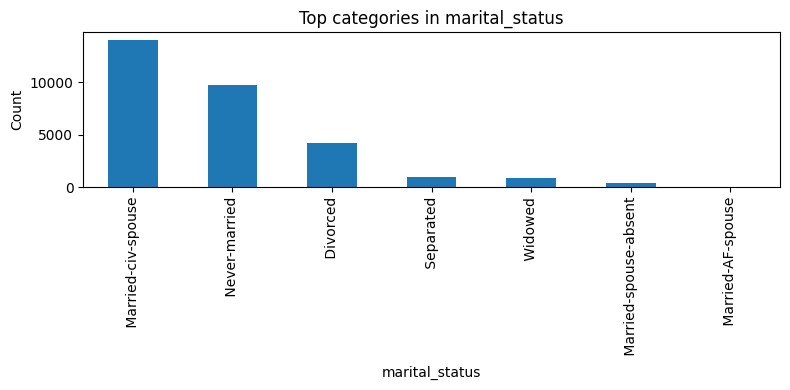

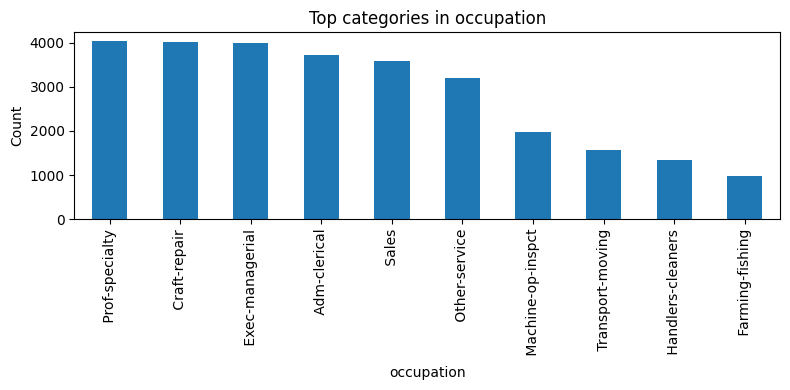

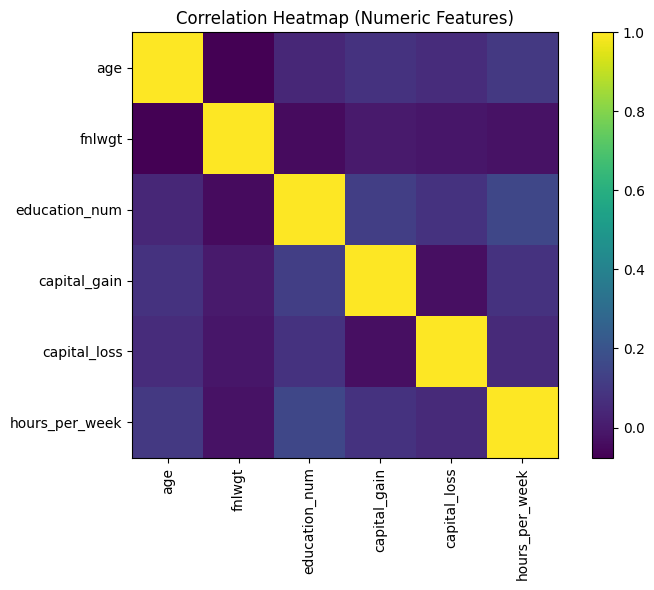

In [7]:
# ============================
# EDA - Exploratory Data Analysis
# ============================

# 1. Target distribution
plt.figure()
class_counts.plot(kind="bar")
plt.title("Income Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 2. Example numeric distributions
for col in numeric_cols[:4]:  # show first few
    plt.figure()
    X[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# 3. Example categorical counts
for col in categorical_cols[:4]:
    plt.figure(figsize=(8,4))
    X[col].value_counts().head(10).plot(kind="bar")
    plt.title(f"Top categories in {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 4. Simple correlation heatmap for numeric features
if len(numeric_cols) > 1:
    corr = X[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation="nearest")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.tight_layout()
    plt.show()


In [8]:
# ============================
# Classical ML models with Pipelines
# ============================

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=RANDOM_STATE
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

pipelines = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf)
    ])
    pipelines[name] = pipe

pipelines


{'LogisticRegression': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'fnlwgt',
                                                    'education_num',
                                                    'capital_gain',
                                                    'capital_loss',
                                                    'hours_per_week']),
                                                  ('cat',
                                                   Pipeline(steps=[('onehot',
                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                   ['workclass', 'education',
                                                  

Positive class treated as: >50K

=== Training LogisticRegression ===
Accuracy:  0.8482
Precision: 0.7394
Recall:    0.6025
F1-score:  0.6640
ROC-AUC:   0.9037


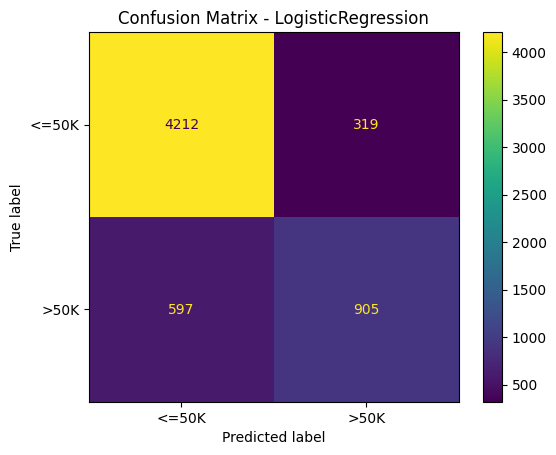


=== Training DecisionTree ===
Accuracy:  0.8114
Precision: 0.6186
Recall:    0.6318
F1-score:  0.6252
ROC-AUC:   0.7513


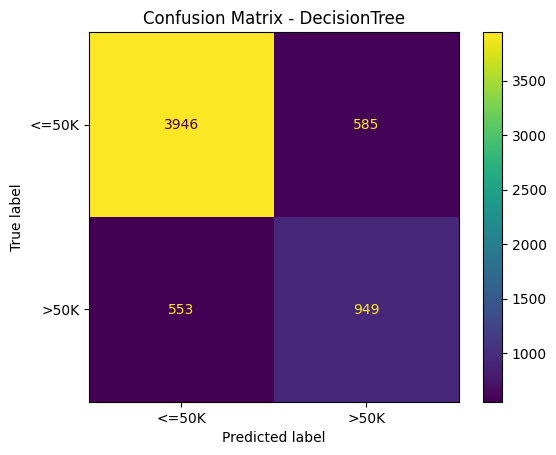


=== Training RandomForest ===
Accuracy:  0.8513
Precision: 0.7300
Recall:    0.6391
F1-score:  0.6816
ROC-AUC:   0.9031


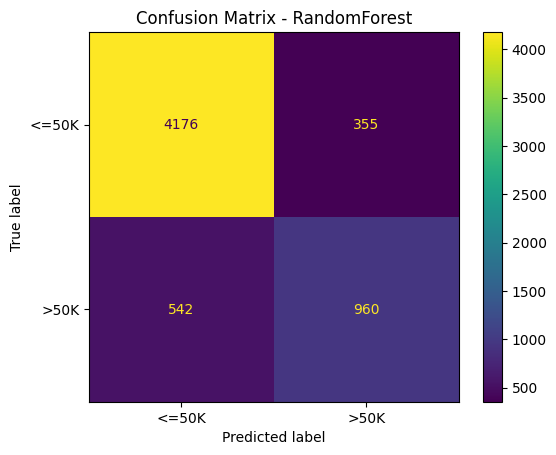


=== Training GradientBoosting ===
Accuracy:  0.8581
Precision: 0.7784
Recall:    0.6012
F1-score:  0.6784
ROC-AUC:   0.9155


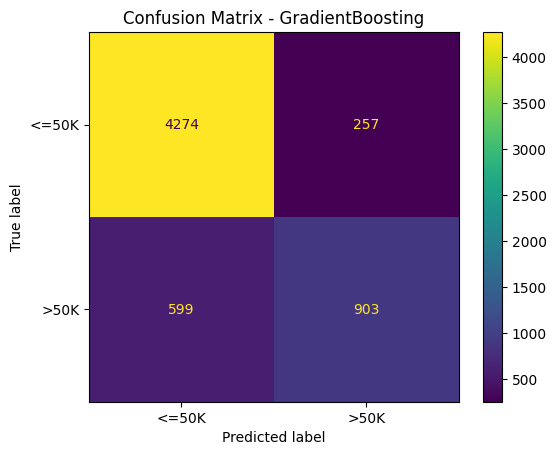


=== Summary of Classical Models ===


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,GradientBoosting,0.858114,0.778448,0.601198,0.678437,0.915458
0,LogisticRegression,0.848168,0.739379,0.602530,0.663977,0.903697
2,RandomForest,0.851318,0.730038,0.639148,0.681576,0.903096
1,DecisionTree,0.811371,0.618644,0.631824,0.625165,0.751316


In [9]:
# ============================
# Train & Evaluate Classical Models
# ============================

results = []

# determine positive class label (should be '>50K' or similar)
positive_label = None
for label in y_train.unique():
    if ">" in label:
        positive_label = label
        break
if positive_label is None:
    # fallback: assume the minority class is positive
    positive_label = y_train.value_counts().idxmin()
print("Positive class treated as:", positive_label)

for name, pipe in pipelines.items():
    print(f"\n=== Training {name} ===")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # some models may not support predict_proba (all ours do, but be safe)
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, list(pipe.named_steps["clf"].classes_).index(positive_label)]
    else:
        # fallback using decision_function if available
        if hasattr(pipe.named_steps["clf"], "decision_function"):
            scores = pipe.decision_function(X_test)
            # scale to 0-1 via min-max
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=positive_label)
    rec = recall_score(y_test, y_pred, pos_label=positive_label)
    f1 = f1_score(y_test, y_pred, pos_label=positive_label)

    if y_proba is not None:
        # binarize true labels
        y_true_bin = (y_test == positive_label).astype(int)
        roc_auc = roc_auc_score(y_true_bin, y_proba)
    else:
        roc_auc = np.nan

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc_auc
    })

    # Confusion matrix (optional for each)
    disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
print("\n=== Summary of Classical Models ===")
results_df


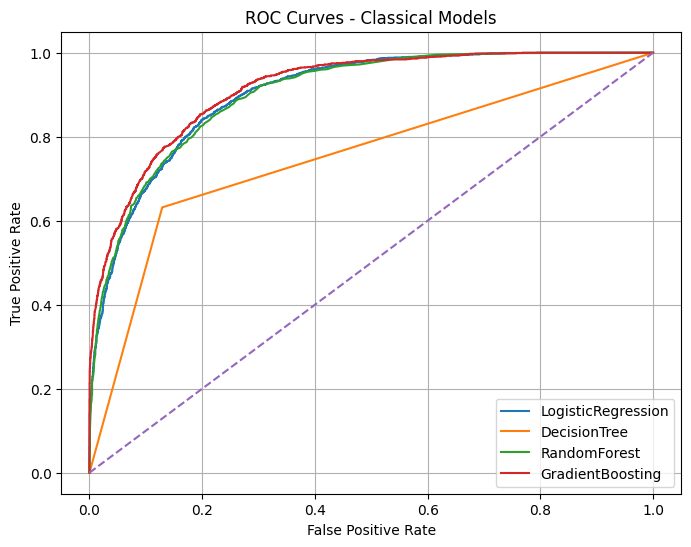

In [10]:
# ============================
# ROC Curves for all classical models
# ============================

plt.figure(figsize=(8,6))

y_true_bin = (y_test == positive_label).astype(int)

for name, pipe in pipelines.items():
    clf = pipe.named_steps["clf"]
    if not hasattr(clf, "predict_proba"):
        continue
    y_proba = pipe.predict_proba(X_test)[:, list(clf.classes_).index(positive_label)]
    fpr, tpr, _ = roc_curve(y_true_bin, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Classical Models")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# ============================
# Identify best classical model (by ROC_AUC)
# ============================

best_row = results_df.iloc[0]
best_model_name = best_row["Model"]
print("Best classical model by ROC-AUC:", best_model_name)
best_clf_pipeline = pipelines[best_model_name]


Best classical model by ROC-AUC: GradientBoosting


In [12]:
# ============================
# Prepare data for ANN (using same preprocessor)
# ============================

# Fit preprocessor on training data
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)

input_dim = X_train_proc.shape[1]


Processed train shape: (24128, 104)
Processed test shape: (6033, 104)


In [26]:
# ============================
# Build ANN model
# ============================

ann_model = tf.keras.models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

ann_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

ann_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ============================
# Train ANN model
# ============================

y_train_bin = (y_train == positive_label).astype(int).values
y_test_bin = (y_test == positive_label).astype(int).values

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = ann_model.fit(
    X_train_proc,
    y_train_bin,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7498 - auc: 0.6789 - loss: 0.5295 - val_accuracy: 0.8328 - val_auc: 0.8966 - val_loss: 0.3493
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8344 - auc: 0.8819 - loss: 0.3611 - val_accuracy: 0.8444 - val_auc: 0.9068 - val_loss: 0.3319
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8425 - auc: 0.8955 - loss: 0.3411 - val_accuracy: 0.8440 - val_auc: 0.9100 - val_loss: 0.3258
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8483 - auc: 0.9003 - loss: 0.3335 - val_accuracy: 0.8492 - val_auc: 0.9117 - val_loss: 0.3222
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8510 - auc: 0.9036 - loss: 0.3286 - val_accuracy: 0.8483 - val_auc: 0.9127 - val_loss: 0.3198
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8524 - auc: 0.9049 - loss: 0.3263 - val_accuracy: 0.8485 - val_auc: 0.9127 - val_loss: 0.3193
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
=== ANN Performance ===
Accuracy:  0.8535
Precision: 0.7265
Recall:    0.6598
F1-score:  0.6916
ROC-AUC:   0.9113


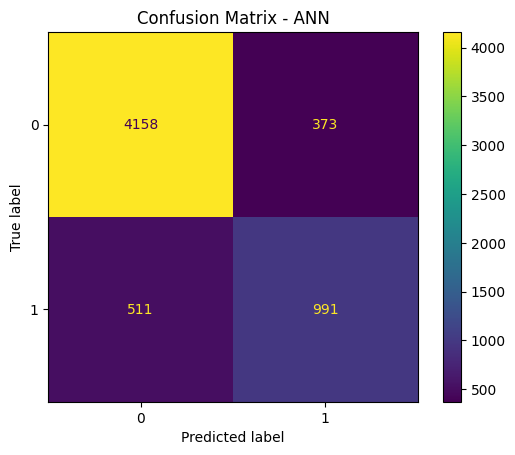

In [18]:
# ============================
# Evaluate ANN
# ============================

ann_probs = ann_model.predict(X_test_proc).ravel()
ann_pred_bin = (ann_probs >= 0.5).astype(int)

ann_acc = accuracy_score(y_test_bin, ann_pred_bin)
ann_prec = precision_score(y_test_bin, ann_pred_bin)
ann_rec = recall_score(y_test_bin, ann_pred_bin)
ann_f1 = f1_score(y_test_bin, ann_pred_bin)
ann_roc_auc = roc_auc_score(y_test_bin, ann_probs)

print("=== ANN Performance ===")
print(f"Accuracy:  {ann_acc:.4f}")
print(f"Precision: {ann_prec:.4f}")
print(f"Recall:    {ann_rec:.4f}")
print(f"F1-score:  {ann_f1:.4f}")
print(f"ROC-AUC:   {ann_roc_auc:.4f}")

# Confusion matrix for ANN
ConfusionMatrixDisplay.from_predictions(y_test_bin, ann_pred_bin)
plt.title("Confusion Matrix - ANN")
plt.show()


In [19]:
# ============================
# Compare Best Classical vs ANN
# ============================

# Evaluate best classical on the same binary basis
best_y_pred = best_clf_pipeline.predict(X_test)
best_y_proba = best_clf_pipeline.predict_proba(X_test)[:, list(best_clf_pipeline.named_steps["clf"].classes_).index(positive_label)]
best_y_pred_bin = (best_y_pred == positive_label).astype(int)

best_acc = accuracy_score(y_test_bin, best_y_pred_bin)
best_prec = precision_score(y_test_bin, best_y_pred_bin)
best_rec = recall_score(y_test_bin, best_y_pred_bin)
best_f1 = f1_score(y_test_bin, best_y_pred_bin)
best_roc_auc = roc_auc_score(y_test_bin, best_y_proba)

comparison_df = pd.DataFrame([
    {
        "Model": best_model_name,
        "Accuracy": best_acc,
        "Precision": best_prec,
        "Recall": best_rec,
        "F1": best_f1,
        "ROC_AUC": best_roc_auc
    },
    {
        "Model": "ANN",
        "Accuracy": ann_acc,
        "Precision": ann_prec,
        "Recall": ann_rec,
        "F1": ann_f1,
        "ROC_AUC": ann_roc_auc
    }
])

comparison_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,GradientBoosting,0.858114,0.778448,0.601198,0.678437,0.915458
1,ANN,0.853473,0.726540,0.659787,0.691556,0.911329


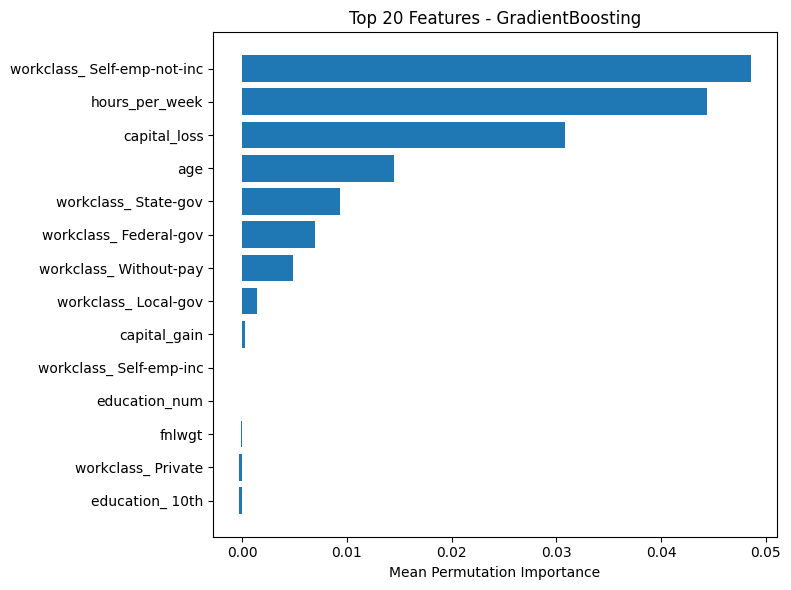

In [20]:
# ============================
# Feature Importance via Permutation Importance
# ============================

# Fit best classical model on full training data (ensuring preprocessor fitted)
best_clf_pipeline.fit(X_train, y_train)

# For permutation importance, use a subset if data is large
X_val = X_test.copy()
y_val = y_test.copy()

perm_result = permutation_importance(
    best_clf_pipeline, X_val, y_val,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Get transformed feature names
ohe = preprocessor.named_transformers_["cat"]["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, cat_feature_names])

importances = perm_result.importances_mean
indices = np.argsort(importances)[::-1][:20]  # top 20

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices][::-1])
plt.xlabel("Mean Permutation Importance")
plt.title(f"Top 20 Features - {best_model_name}")
plt.tight_layout()
plt.show()


In [27]:
# ============================
# Unsupervised Clustering (K-Means)
# ============================

from scipy.sparse import vstack as sparse_vstack # Import sparse vstack

# Use processed features for clustering
# (We already have X_train_proc, X_test_proc)
X_all_proc = sparse_vstack([X_train_proc, X_test_proc]) # Use sparse_vstack for sparse matrices
y_all_bin = np.concatenate([y_train_bin, y_test_bin])

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_all_proc)

print("Cluster counts:", np.bincount(clusters))

# Compare with true income labels
cm_clusters = pd.crosstab(clusters, y_all_bin, rownames=["Cluster"], colnames=["Income (>50K)"])
cm_clusters


Cluster counts: [14657 15504]


Income (>50K),0,1
Cluster,,
0,13900,757
1,8753,6751


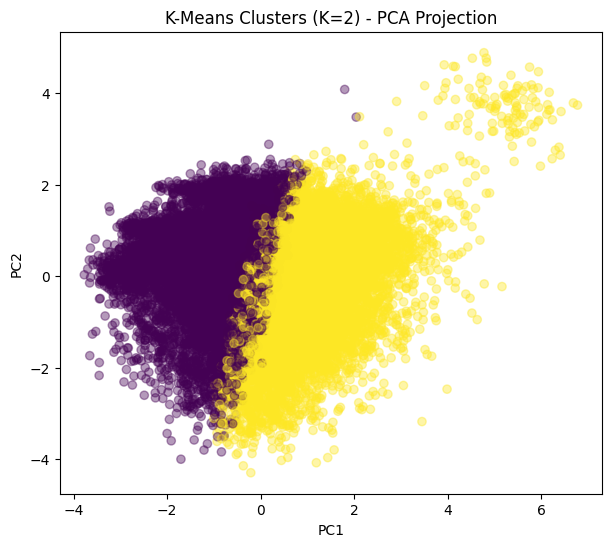

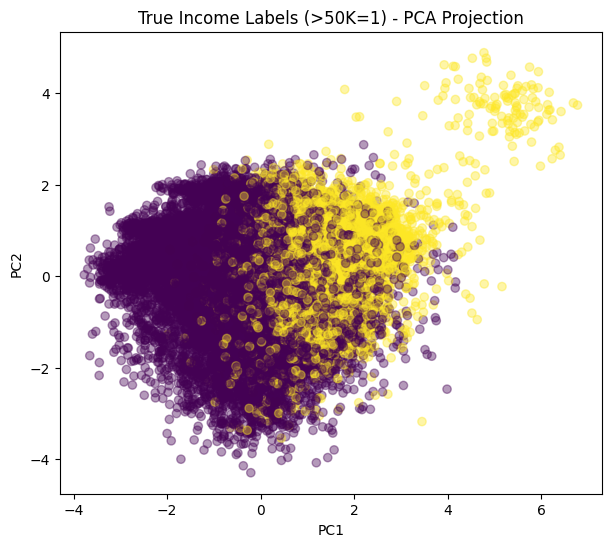

In [29]:
# ============================
# PCA for Visualisation
# ============================

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_all_proc)

# Plot by clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, alpha=0.4)
plt.title("K-Means Clusters (K=2) - PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Plot by true label
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_all_bin, alpha=0.4)
plt.title("True Income Labels (>50K=1) - PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
